In [26]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import imageio
sys.path.append("C:\\users\\mccar\\miniconda3\\lib\\site-packages")

# from keras.models import Sequential
# from keras.layers import Dense, Dropout
# from keras.optimizers import Adam
# from keras.models import load_model
# from keras.utils import plot_model
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

In [27]:
# Load the environment a get the number of actions and states
env = gym.make('LunarLander-v2')
env.reset()
print(env.observation_space.shape)
print(env.action_space.n)

(8,)
4


Episode finished after 114 timesteps


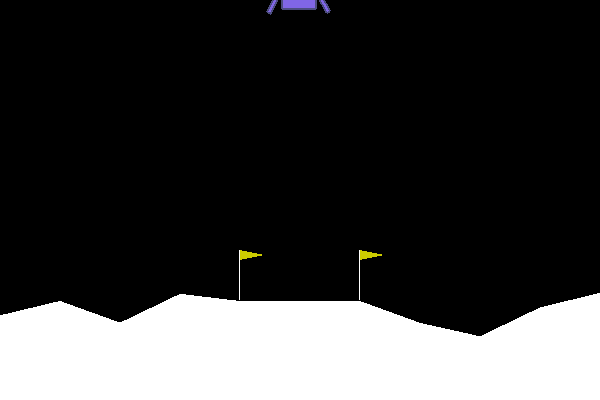

In [28]:
"""
Agent here just takes random actions and we will show the results in gif form
"""
frames = []

for i_episode in range(1):
    
    observation = env.reset()
    for t in range(200):
        # show the lander
        # env.render()
        frames.append(env.render(mode='rgb_array'))
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

gif_path = './lunar_lander.gif'
imageio.mimsave(gif_path, frames, duration=20)

from IPython.display import HTML, Image
# HTML('<img src="./project2_random_action.gif">')
# Display the GIF
Image(filename=gif_path)

In [29]:
"""
Deep Q Learning Network
"""

class DQN:
    def __init__(self, env, gamma = 0.99, lr = 5e-4, tau = 1e-3):
        # set the environment
        self.env = env
        
        # Initialize the replay buffer
        # Use deque for its property of auto-discarding stored elements if it is full
        self.replay_buffer  = deque(maxlen=int(1e5))
        
        # discount factor gamma
        self.gamma = gamma
        # learning rate
        self.lr = lr
        # soft update rate
        self.tau = tau 
        
        # construct one model for action-value function
        # construct another target_model for target action-value function
        # off policy learning
        # target model is used to generate value estimate and make action selection
        # model is learning from experience and improve estimate
        self.model,  self.target_model  = self.init_model(), self.init_model()
        self.opt = optim.Adam(self.model.parameters(), lr=lr)
        self.opt_targ = optim.Adam(self.target_model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
        # Every C step soft update target model Q_hat to model Q
        self.C = 4
        # batch size in learning
        self.batch_size = 64
        # Counter
        self.t = 0
    
    def init_model(env, lr):
        """
        Create pytorch model
        """
        class NeuralNetwork(nn.Module):
            def __init__(self, input_shape, output_shape):
                super(NeuralNetwork, self).__init__()
                self.fc1 = nn.Linear(input_shape, 64)
                self.fc2 = nn.Linear(64, 64)
                self.fc3 = nn.Linear(64, output_shape)

            def forward(self, x):
                x = torch.relu(self.fc1(x))
                x = torch.relu(self.fc2(x))
                x = self.fc3(x)
                return x

        input_shape = env.observation_space.shape[0]
        output_shape = env.action_space.n

        model = NeuralNetwork(input_shape, output_shape)
        return model


    # def init_model(self):
    #     # create keras NN model
    #     # set input and output shape 
    #     # input shape is the dimension of state space (8,1)
    #     # output shape is the dimension of actions (4,1)
    #     input_shape = self.env.observation_space.shape[0]
    #     output_shape = self.env.action_space.n
        
    #     # Define Sequential model (linear stack of layers)  
    #     # Add hidden layers: two hidden layers with the size of 64
    #     model = Sequential()        
    #     model.add(Dense(64, input_dim=input_shape, activation="relu"))
    #     model.add(Dense(64, activation="relu"))
    #     model.add(Dense(output_shape))
        
    #     # Define the loss function of mse, Use Adam for optimization
    #     model.compile(loss="mean_squared_error",optimizer=Adam(learning_rate=self.lr))
    #     return model


    def add_to_buffer(self, state, action, reward, new_state, done):
        # Store transition to replay buffer
        self.replay_buffer.append([state, action, reward, new_state, done])

    
    def generate_action(self, state, eps):
        # Take action with epsilon-greedy respect to action-value function prediction from model
        if np.random.random() < eps:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])
    
    
    def train_target(self):
        # soft update to target model Q_hat from model Q
        # target model and model are not updating at the same time
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = self.tau * weights[i] + (1 - self.tau) * target_weights[i]
        # assign new weights to target model
        self.target_model.set_weights(target_weights)

    
    def learning(self):
        # the batch learning (gradient descent) of the model Q
        # incrememnt counter
        self.t = (self.t + 1) % self.C
        
        # update every C times and make sure buffer is filled with at least size batch size
        # counter will be zeored from the mod calc above
        if self.t == 0:
            if len(self.replay_buffer) < self.batch_size: 
                return
            
            # init list states to store states 
            # init list of targets values forecast gernated by model Q associated with each state-action
            states, targets_forecast = [], []
            
            # random sample from replay buffer - take 64 replay samples
            samples = random.sample(self.replay_buffer, self.batch_size)
            
            # iterate through each sample
            for state, action, reward, new_state, done in samples:
                if done:
                    # if the episode is done, the target is the reward
                    target = reward
                else:
                    # if not done, get new state based on best action from target model
                    Q_new_state =  np.amax(self.target_model.predict(new_state)[0])
                    # target is the reward plus the discounted future reward
                    target = reward + self.gamma *  Q_new_state

                # get the forecasted values from model Q
                target_forecast = self.model.predict(state)
                target_forecast[0][action] = target
                
                # append to lists for batch processing outside the iteartion
                states.append(state[0])
                targets_forecast.append(target_forecast[0])
            
            # batch learning to train the model Q
            self.model.fit(np.array(states), np.array(targets_forecast), epochs=1, verbose=0)
            self.train_target()
    
    # save complete model
    def save_model(self, fn):
        self.model.save(fn)

In [30]:
"""
Train the DQN agent
"""

def train(gamma = 0.99, lr = 5e-4, tau = 1e-3, epsilon_decay = 0.995):
    """
    train function
    """
    # Load the environment
    env = gym.make("LunarLander-v2")
    
    # Define the epsilon and its decay for epsilon-greedy action selection
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = epsilon_decay
    
    # Define no.of training episodes and max steps for each episode
    episodes  = 10
    steps = 1000

    # scores store all score in each trial
    # scores_window stores last 100 trial scores
    scores = []                        
    scores_window = deque(maxlen=100)
    
    # epsilons store all epsilon values:
    epsilons = []
    
    # init the DQN agent
    agent = DQN(env=env, gamma=gamma, lr=lr, tau=tau)
    
    # each trial
    for trial in range(episodes):
        # initializations
        score = 0
        cur_state = env.reset().reshape(1,8)
        epsilons.append(epsilon)
        
        # each step in an training trial/episode
        for step in range(steps):
            #env.render()
            
            # get action from agent and take that action
            action = agent.generate_action(cur_state ,epsilon)
            new_state, reward, done, info = env.step(action)
            score += reward
            new_state = new_state.reshape(1,8)
            
            # add experience to replay buffer
            agent.add_to_buffer(cur_state, action, reward, new_state, done)
            
            # learning from current step
            agent.learning()
            cur_state = new_state
        
            if done:
                break   
        
        scores.append(score)
        scores_window.append(score)
        
        # decay of epsilon, in early training, perform more exploration
        # at later stage of training, perform more exploitation
        epsilon *= epsilon_decay
        epsilon = max(epsilon_min, epsilon)
        
        print('\rtrial {}\t Mean Score: {:.3f} \t with epsilon: {:.3f}'.format(trial, np.mean(scores_window), epsilon), end="")
        
        if trial % 100 == 0:
            print('\rtrial {}\t Mean Score: {:.3f}'.format(trial, np.mean(scores_window)))
        
        # stop if last 100 consecutive scores, save the model/agent
        # this is how we define convergence
        if np.mean(scores_window)>=200.0:
            agent.save_model("dqn_model.h5")
            print('\n Achieve Mean Score of 200 for past 100 trials with total {:d} trial!\tAverage Score: {:.3f}'.format(trial-100, np.mean(scores_window)))
            break                     
    
    env.close()
    return (scores,epsilons)

In [31]:
"""
Function for testing with the trained DQN model
"""
frames = []

def test(saved_model):    
    
    # Keras load trained agent
    model = load_model(saved_model)
    
    # summary of the value-action model Q
    model.summary()
    
    # plot model structure
    plot_model(model, show_shapes = True, to_file='model.png')
    print("model weights:", model.get_weights()) 
   
    # test the trained agent
    env = gym.make("LunarLander-v2")
    scores = []
    
    # run the trained agent 100 trials
    for trial in range(10):
        score = 0
        cur_state = env.reset().reshape(1,8)
        for step in range(1000):
            frames.append(env.render(mode='rgb_array'))
            # take action based on the best action from model Q
            action = np.argmax(model.predict(cur_state)[0])
            # get new state, reward
            new_state, reward, done, trunc, info = env.step(action)
            new_state = new_state.reshape(1,8)
            score += reward
            cur_state = new_state
            if done:
                break   
        
        scores.append(score)
        print('\rtrial {}\t Score: {:.3f}'.format(trial, (score)), end="")
              
    env.close()
    return scores

In [32]:
def plot_values(values, xlabel, ylabel):
    """
    plot the values
    """
    fig = plt.figure()
    plt.plot(np.arange(len(values)), values)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [33]:
# train and plot using default parameters
train_scores, epsilons = train()

plot_values(train_scores, "Trials", "Scores")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

KeyboardInterrupt: 

In [ ]:
# test and plot
test_scores = test("dqn_model.h5")

gif_path = './lunar_lander_complete.gif'
imageio.mimsave(gif_path, frames, duration=20)

from IPython.display import HTML, Image
# HTML('<img src="./project2_random_action.gif">')
# Display the GIF
Image(filename=gif_path)

plot_values(test_scores, "Trails", "Scores")
print("Average Score of 10 trials: {:.3f}".format(np.mean(test_scores)))

plot_values(epsilons, "Trails", "Epsilons")